<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/getStormTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Retrives the track of a single hurricane from tropycal. Also saves track subsetted by category or intensitifcation rate.

## Set up environment.

Track data comes from [tropycal](https://tropycal.github.io/tropycal/install.html).

In [123]:
!pip install tropycal
!pip install cartopy

In [124]:
from tropycal import tracks, rain
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

User Inputs

In [147]:
# Basin and year
myBasin = 'north_atlantic'
year = 2024
name = "Milton"

intThreshold = 96 # Threshold for a major hurricane in kt
riThreshold = 30 # Intensification threshold in riTime for RI in kt
riTime = 24 # in hr

Retrieve storm

In [126]:
# Initialize
# https://tropycal.github.io/tropycal/api/generated/tropycal.tracks.TrackDataset.html#tropycal.tracks.TrackDataset

basin = tracks.TrackDataset(basin=myBasin, source='hurdat', include_btk=True) # include most recent season
season = basin.get_season(year)
tc = season.get_storm((name, year))
print(tc)

--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (9.22 seconds)
--> Starting to read in best track data
--> Completed reading in best track data (0.18 seconds)
<tropycal.tracks.Storm>
Storm Summary:
    Maximum Wind:      155 knots
    Minimum Pressure:  895 hPa
    Start Time:        1200 UTC 05 October 2024
    End Time:          1200 UTC 10 October 2024

Variables:
    time        (datetime) [2024-10-04 18:00:00 .... 2024-10-11 18:00:00]
    extra_obs   (int64) [0 .... 0]
    special     (str) [ .... ]
    type        (str) [LO .... EX]
    lat         (float64) [21.0 .... 29.3]
    lon         (float64) [-94.6 .... -65.9]
    vmax        (int64) [30 .... 50]
    mslp        (int64) [1009 .... 999]
    wmo_basin   (str) [north_atlantic .... north_atlantic]

More Information:
    id:              AL142024
    operational_id:  AL142024
    name:            MILTON
    year:            2024
    season:          2024
    basin:           north_atlantic
    sourc

Plot TC track

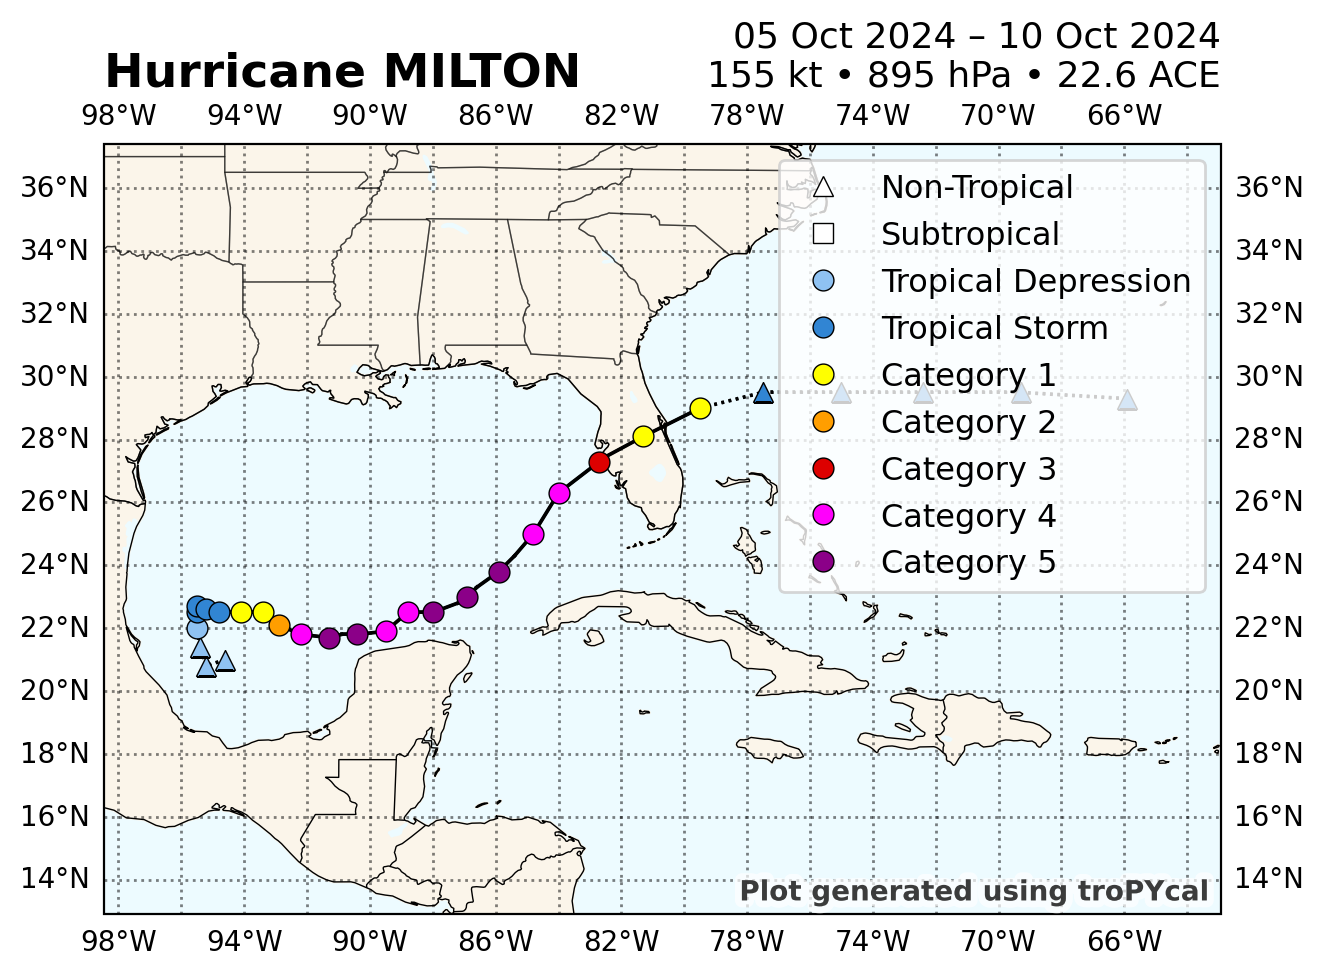

In [127]:
tc.plot(map_prop={'figsize':(8,5),'linewidth':0.5, 'state_alpha':0.5})
plt.savefig('hurdat2_{}.png'.format(name))

Save whole storm track

In [128]:
tc_DF = tc.to_dataframe()
tc_DF.to_csv('hurdat2_{}.csv'.format(name))

In [129]:
tc_DF

,time,extra_obs,special,type,lat,lon,vmax,mslp,wmo_basin
0,2024-10-04 18:00:00,0,,LO,21.0,-94.6,30,1009,north_atlantic
1,2024-10-05 00:00:00,0,,LO,20.8,-95.2,30,1008,north_atlantic
2,2024-10-05 06:00:00,0,,LO,21.4,-95.4,30,1008,north_atlantic
3,2024-10-05 12:00:00,0,,TD,22.0,-95.5,30,1008,north_atlantic
4,2024-10-05 18:00:00,0,,TS,22.5,-95.5,35,1006,north_atlantic
5,2024-10-06 00:00:00,0,,TS,22.7,-95.5,35,1004,north_atlantic
6,2024-10-06 06:00:00,0,,TS,22.6,-95.2,45,999,north_atlantic
7,2024-10-06 12:00:00,0,,TS,22.5,-94.8,55,991,north_atlantic
8,2024-10-06 18:00:00,0,,HU,22.5,-94.1,70,986,north_atlantic
9,2024-10-07 00:00:00,0,,HU,22.5,-93.4,75,981,north_atlantic


Subset by category

In [130]:
tcMajor = tc_DF[tc_DF.vmax >= intThreshold].reset_index()
tcMajor.to_csv("hurdat2_{}_major.csv".format(name))

In [131]:
tcMajor

,index,time,extra_obs,special,type,lat,lon,vmax,mslp,wmo_basin
0,11,2024-10-07 12:00:00,0,,HU,21.8,-92.2,120,943,north_atlantic
1,12,2024-10-07 18:00:00,0,,HU,21.7,-91.3,150,908,north_atlantic
2,13,2024-10-07 20:00:00,1,I,HU,21.8,-90.9,155,895,north_atlantic
3,14,2024-10-08 00:00:00,0,,HU,21.8,-90.4,145,902,north_atlantic
4,15,2024-10-08 06:00:00,0,,HU,21.9,-89.5,125,925,north_atlantic
5,16,2024-10-08 12:00:00,0,,HU,22.5,-88.8,125,929,north_atlantic
6,17,2024-10-08 18:00:00,0,,HU,22.5,-88.0,140,916,north_atlantic
7,18,2024-10-08 22:05:00,1,R,HU,22.8,-87.2,145,902,north_atlantic
8,19,2024-10-09 00:00:00,0,,HU,23.0,-86.9,140,908,north_atlantic
9,20,2024-10-09 02:05:00,1,R,HU,23.3,-86.6,135,916,north_atlantic


Subset by Rapid Intensification

In [180]:
#This only works for TCs with a single RI episode in its lifetime
riStart = None
riEnd = None

for row in tc_DF.iloc:
  futureTime = row.time + pd.Timedelta(hours=riTime)

  if futureTime in list(tc_DF.time):
    intensification = float(tc_DF[tc_DF.time == futureTime].vmax - row.vmax)
    if intensification >= riThreshold and riStart == None: riStart = row.time
    #if intensification < riThreshold and riStart != None and riEnd == None: riEnd = row.time

In [181]:
riStart

Timestamp('2024-10-05 18:00:00')

In [183]:
riEnd = max(tc_DF[tc_DF.vmax==max(tc_DF.vmax)].time) #This only works for a TC where RI ends once the TC reaches its peak intensity

In [184]:
riEnd

Timestamp('2024-10-07 20:00:00')

In [190]:
postRIStart = tc_DF[tc_DF.time >= riStart]
tcRI = postRIStart[postRIStart.time <= riEnd].reset_index()
tcRI.to_csv("hurdat2_{}_RI.csv".format(name))

In [191]:
tcRI

,index,time,extra_obs,special,type,lat,lon,vmax,mslp,wmo_basin
0,4,2024-10-05 18:00:00,0,,TS,22.5,-95.5,35,1006,north_atlantic
1,5,2024-10-06 00:00:00,0,,TS,22.7,-95.5,35,1004,north_atlantic
2,6,2024-10-06 06:00:00,0,,TS,22.6,-95.2,45,999,north_atlantic
3,7,2024-10-06 12:00:00,0,,TS,22.5,-94.8,55,991,north_atlantic
4,8,2024-10-06 18:00:00,0,,HU,22.5,-94.1,70,986,north_atlantic
5,9,2024-10-07 00:00:00,0,,HU,22.5,-93.4,75,981,north_atlantic
6,10,2024-10-07 06:00:00,0,,HU,22.1,-92.9,90,972,north_atlantic
7,11,2024-10-07 12:00:00,0,,HU,21.8,-92.2,120,943,north_atlantic
8,12,2024-10-07 18:00:00,0,,HU,21.7,-91.3,150,908,north_atlantic
9,13,2024-10-07 20:00:00,1,I,HU,21.8,-90.9,155,895,north_atlantic
